# Vector Visualization

## Preparation

### Models and data

```bash
$ just prepare-for-build-rag
```

### Required Packages

In [25]:
from glob import glob
import json

import ollama
from pymilvus import connections, db, MilvusClient
from tqdm import tqdm

### Prepare the Data

In [3]:
text_lines = []

for file_path in glob("../../milvus_docs/en/faq/*.md", recursive=True):
    with open(file_path, "r") as file:
        file_text = file.read()

    text_lines += file_text.split("# ")

print(text_lines)

['---\nid: operational_faq.md\nsummary: Find answers to commonly asked questions about operations in Milvus.\ntitle: Operational FAQ\n---\n\n', 'Operational FAQ\n\n<!-- TOC -->\n\n\n<!-- /TOC -->\n\n###', 'What if I failed to pull the Milvus Docker image from Docker Hub?\n\nIf you failed to pull the Milvus Docker image from Docker Hub, try adding other registry mirrors. \n\nUsers from Mainland China can add the URL "https://registry.docker-cn.com" to the registry-mirrors array in **/etc.docker/daemon.json**.\n\n```\n{\n  "registry-mirrors": ["https://registry.docker-cn.com"]\n}\n```\n\n###', 'Is Docker the only way to install and run Milvus?\n\nDocker is an efficient way to deploy Milvus, but not the only way. You can also deploy Milvus from source code. This requires Ubuntu (18.04 or higher) or CentOS (7 or higher). See [Building Milvus from Source Code](https://github.com/milvus-io/milvus#build-milvus-from-source-code) for more information.\n\n###', 'What are the main factors affecti

## Prepare the Embedding Model

In [5]:
def emb_text(text):
    response = ollama.embed(model="mxbai-embed-large", input=text)
    embeddings = response["embeddings"]
    return embeddings

In [16]:
test_embedding = emb_text("This is a test")
embedding_dim = len(test_embedding[0])
print(embedding_dim)

1024


## Load data into Milvus

In [17]:
uri = "http://localhost:19530"
db_name = "milvus_demo"
collection_name = "my_rag_collection"

# DB 생성
connections.connect(uri=uri)
if db_name not in db.list_database():
    db.create_database(db_name)

In [18]:
milvus_client = MilvusClient(uri=uri)

if milvus_client.has_collection(collection_name):
    milvus_client.drop_collection(collection_name)

In [19]:
milvus_client.create_collection(
    collection_name=collection_name,
    dimension=embedding_dim,
    metric_type="IP",  # Inner product distance
    consistency_level="Strong",  # Strong consistency level
)

### Insert data

In [22]:
data = []

for i, line in enumerate(tqdm(text_lines, desc="Creating embeddings")):
    data.append({"id": i, "vector": emb_text(line)[0], "text": line})

milvus_client.insert(collection_name=collection_name, data=data)

Creating embeddings: 100%|██████████| 72/72 [00:02<00:00, 34.55it/s]


{'insert_count': 72, 'ids': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71], 'cost': 0}

## Visualizing Embeddings in Vector Search

In [23]:
# Modify the question to test it with your own query!

question = "How is data stored in Milvus?"

In [24]:
search_res = milvus_client.search(
    collection_name=collection_name,
    data=[
        emb_text(question)[0]
    ],  # Use the `emb_text` function to convert the question to an embedding vector
    limit=10,  # Return top 10 results
    search_params={"metric_type": "IP", "params": {}},  # Inner product distance
    output_fields=["text"],  # Return the text field
)

In [26]:
retrieved_lines_with_distances = [
    (res["entity"]["text"], res["distance"]) for res in search_res[0]
]
print(json.dumps(retrieved_lines_with_distances, indent=4))

[
    [
        " Where does Milvus store data?\n\nMilvus deals with two types of data, inserted data and metadata. \n\nInserted data, including vector data, scalar data, and collection-specific schema, are stored in persistent storage as incremental log. Milvus supports multiple object storage backends, including [MinIO](https://min.io/), [AWS S3](https://aws.amazon.com/s3/?nc1=h_ls), [Google Cloud Storage](https://cloud.google.com/storage?hl=en#object-storage-for-companies-of-all-sizes) (GCS), [Azure Blob Storage](https://azure.microsoft.com/en-us/products/storage/blobs), [Alibaba Cloud OSS](https://www.alibabacloud.com/product/object-storage-service), and [Tencent Cloud Object Storage](https://www.tencentcloud.com/products/cos) (COS).\n\nMetadata are generated within Milvus. Each Milvus module has its own metadata that are stored in etcd.\n\n###",
        0.8473492860794067
    ],
    [
        "How does Milvus flush data?\n\nMilvus returns success when inserted data are loaded to t

### Dimensionality reduction to 2-d by t-SNE

In [27]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE

In [28]:
data.append({"id": len(data), "vector": emb_text(question)[0], "text": question})
embeddings = []
for gp in data:
    embeddings.append(gp["vector"])

X = np.array(embeddings, dtype=np.float32)
tsne = TSNE(random_state=0, max_iter=1000)
tsne_results = tsne.fit_transform(X)

df_tsne = pd.DataFrame(tsne_results, columns=["TSNE1", "TSNE2"])
df_tsne

,TSNE1,TSNE2
0,7.695630,-1.730338
1,8.393435,-0.830472
2,1.889391,0.180548
3,1.120985,-1.059213
4,7.828493,-7.858887
...,...,...
68,6.215613,-7.621928
69,3.911878,-7.977952
70,3.929384,-7.819191
71,3.928445,-1.743621


### Visualizing Milvus search results on a 2d plane

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

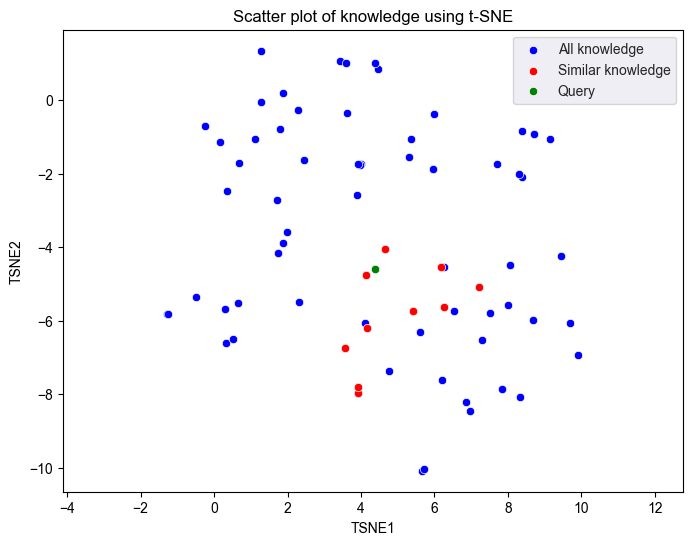

In [31]:
# Extract similar ids from search results
similar_ids = [gp["id"] for gp in search_res[0]]

df_norm = df_tsne[:-1]

df_query = pd.DataFrame(df_tsne.iloc[-1]).T

# Filter points based on similar ids
similar_points = df_tsne[df_tsne.index.isin(similar_ids)]

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))  # Set figsize

# Set the style of the plot
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

# Plot all points in blue
sns.scatterplot(
    data=df_tsne,
    x="TSNE1",
    y="TSNE2",
    color="blue",
    label="All knowledge",
    ax=ax
)

# Overlay similar points in red
sns.scatterplot(
    data=similar_points,
    x="TSNE1",
    y="TSNE2",
    color="red",
    label="Similar knowledge",
    ax=ax,
)

sns.scatterplot(
    data=df_query,
    x="TSNE1",
    y="TSNE2",
    color="green",
    label="Query",
    ax=ax
)

# Set plot titles and labels
plt.title("Scatter plot of knowledge using t-SNE")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")

# Set axis to be equal
plt.axis("equal")

# Display the legend
plt.legend()

# Show the plot
plt.show()